In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
# from sklearn.metrics import f1_score

In [2]:
data = np.load("../data/energy_pdfs.npz")
pdf_A = data['pdf_A']
pdf_B  = data['pdf_B']
pdf_C = data['pdf_C']
pdf_ovbb = data['pdf_ovbb']
bin_edges = data['bin_edges']
bin_centers = data['bin_centers']
counts_Target = data['counts_Target']

In [7]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges):
    """
    Fit DetectorTarget histogram with template PDFs and show uncertainties.
    """
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Model chi2 function
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb) * bin_width
        return np.sum((counts_Target - model)**2 / (model + 1e-6))  # avoid div0

    # Initial guess
    m = Minuit(chi2, theta_A=500, theta_B=300, theta_C=100, theta_ovbb=10)
    m.errordef = 1  # chi2
    m.limits = [(0, None), (0, None), (0, None), (0, None)]
    m.migrad()

    # Extract fit values and errors
    theta_fit = m.values
    theta_err = m.errors

    print("Fitted θ values ± 1σ:")
    for i, name in enumerate(['theta_A', 'theta_B', 'theta_C', 'theta_ovbb']):
        print(f"{name} = {theta_fit[i]:.2f} ± {theta_err[i]:.2f}")

    # Model counts
    model_counts = (theta_fit['theta_A']*pdf_A +
                    theta_fit['theta_B']*pdf_B +
                    theta_fit['theta_C']*pdf_C +
                    theta_fit['theta_ovbb']*pdf_ovbb) * bin_width

    # Propagate uncertainties to model counts
    model_err = np.sqrt(
        (pdf_A * theta_err['theta_A'])**2 +
        (pdf_B * theta_err['theta_B'])**2 +
        (pdf_C * theta_err['theta_C'])**2 +
        (pdf_ovbb * theta_err['theta_ovbb'])**2
    ) * bin_width

    # Setup figure with ratio subplot
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    # Main histogram
    ax_main.bar(bin_centers, counts_Target, width=bin_width, color='gray', alpha=0.6, label='Data')
    ax_main.step(bin_centers, model_counts, color='red', where='mid', label='Fit')
    ax_main.set_ylabel("Counts / bin")
    ax_main.set_title("DetectorTarget Fit with Template PDFs")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # Ratio plot
    mask = counts_Target > 2  # ignore bins with less than 2 counts
    ratio = model_counts[mask] / counts_Target[mask]
    ax_ratio.step(bin_centers[mask], ratio, color='blue', where='mid')
    ax_ratio.axhline(1, color='black', linestyle='--')
    ax_ratio.set_xlabel("Energy (keV)")
    ax_ratio.set_ylabel("Fit / Data")
    ax_ratio.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return theta_fit, theta_err


Fitted θ values ± 1σ:
theta_A = 410.62 ± 88.96
theta_B = 591.72 ± 84.93
theta_C = 426.17 ± 87.43
theta_ovbb = 10.12 ± 4.01


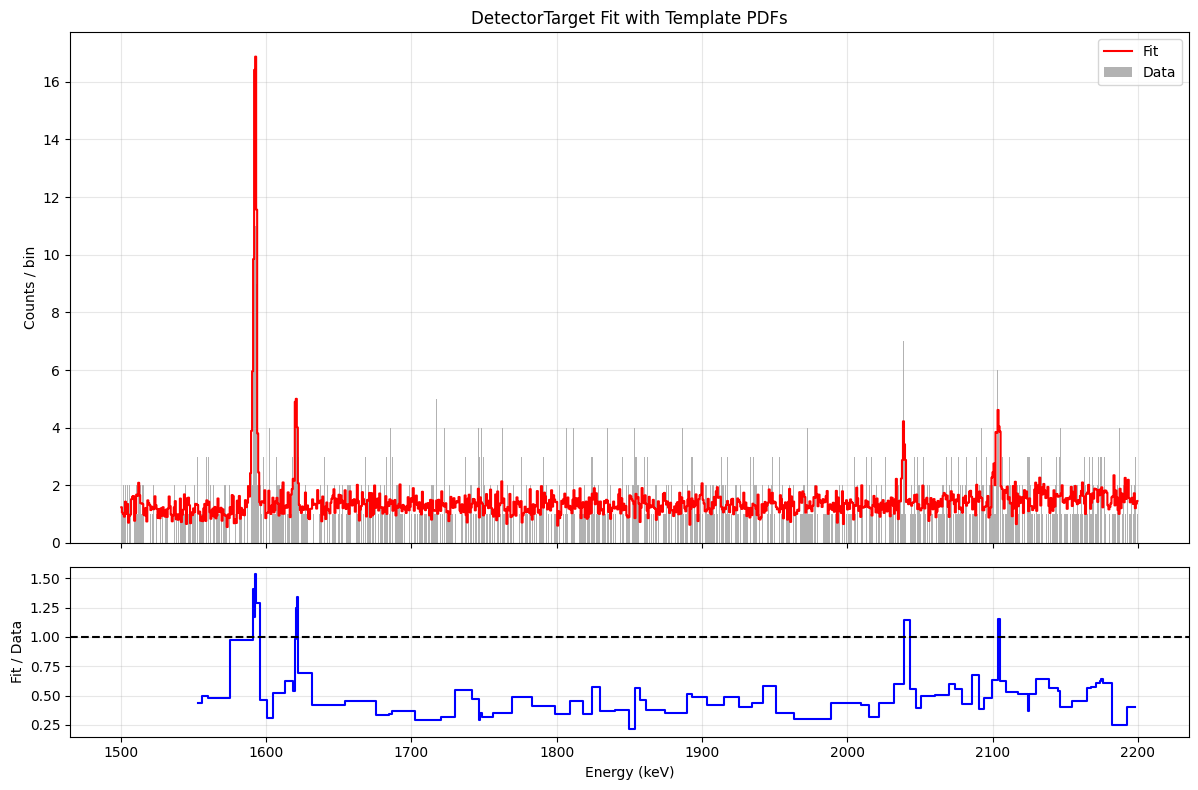

In [8]:
theta_fit, theta_error = fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges)